# RSVQA low resolution


This page describes the usage of Dataloader and Datamodule for [the low resolution version of RSVQA](https://zenodo.org/record/6344334), a VQA dataset based on Sentinel-2 images over the Netherlands. It was first published by {cite:t}`rsvqa`. The dataset can be found on zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6344334.svg)](https://doi.org/10.5281/zenodo.6344334).
A small example of the data used is distributed with this package.

This module contains two `classes`, a standard `torch.util.data.Dataset` and a `pytorch_lightning.LightningDataModule` that encapsulates the `Dataset` for easy use in `pytorch_lightning` applications. Questions and Answers are read using JSON files.

In [28]:
# remove-input
# remove-output
import matplotlib.pyplot as plt
import pathlib
from pprint import pprint
import torch

my_data_path = str(pathlib.Path("").resolve().parent.parent.parent.joinpath("configilm").joinpath("extra").joinpath("mock_data").joinpath("RSVQA-LR").resolve(strict=True))

## RSVQALRDataSet

In its most basic form, the `Dataset` only needs the base path to the image and json files, if the path is not "./". The folder structure should follow the structure found online in the official zenodo directory.

The full folder structure expected for the data is
```
├── Images_LR
│   ├── 1.tif
.         .
│   └── 9999.tif
├── LR_split_test_answers.json
├── LR_split_test_images.json
├── LR_split_test_questions.json
├── LR_split_train_answers.json
├── LR_split_train_images.json
├── LR_split_train_questions.json
├── LR_split_val_answers.json
├── LR_split_val_images.json
└── LR_split_val_questions.json
```

In [29]:
# remove-output
from configilm.extra.DataSets import RSVQALR_DataSet
 
ds = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path  # path to dataset
)

img, question, answer = ds[4]
img = torch.flip(img, [0]) # only choose BGR axis for display and bring into RGB order



The 1000 most frequent answers cover about 100.00 % of the total answers.


Size: torch.Size([3, 256, 256])
Question (start): [101, 2054, 2003, 1996, 3815, 1997, 4925, 1029, 102, 0, 0, 0, 0, 0, 0]
Answer (start): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


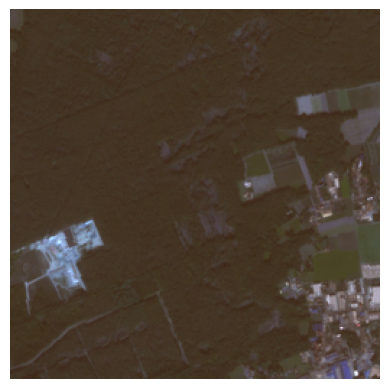

In [30]:
# remove-input
print(f"Size: {img.shape}")
print(f"Question (start): {question[:15]}")
print(f"Answer (start): {answer[:15]}")

_ = plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Tokenizer and Tokenization

As we can see, this Dataset uses a tokenizer to generate the Question out of a natural language text. If no tokenizer is provided, a default one will be used, however this may lead to bad performance if not accounted for. The tokenizer can be configured as input parameter.

In [4]:
# remove-output
from configilm.ConfigILM import _get_hf_model

tokenizer, _ = _get_hf_model("prajjwal1/bert-tiny")

ds = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    tokenizer=tokenizer
)
img, question, answer = ds[0]


The 1000 most frequent answers cover about 100.00 % of the total answers.


:::{tip}
Usually this tokenizer is provided by the model itself as shown in the [VQA example](../../vqa.ipynb) during dataset creation.
:::

During tokenization a sequence of tokens (integers) of specific length is generated. The length of this sequence can be set with the parameter `seq_length`. If the generated tokens are shorter than the sequence length, the sequence will be padded with zeros. If it is longer, the sequence is truncated.
:::{note}
Most tokenizer use an 'End of Sequence' token that will always be the last one in the non-padded sequence.
:::

In [5]:
# remove-output
ds = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    tokenizer=tokenizer,
    seq_length=16
)
_, question1, _ = ds[0]
print(question1)


The 1000 most frequent answers cover about 100.00 % of the total answers.
[101, 2003, 2009, 1037, 3541, 2030, 2019, 3923, 2181, 102, 0, 0, 0, 0, 0, 0]


In [6]:
# remove-input
print(question1)

[101, 2003, 2009, 1037, 3541, 2030, 2019, 3923, 2181, 102, 0, 0, 0, 0, 0, 0]


In [7]:
# remove-output
ds = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    tokenizer=tokenizer,
    seq_length=8
)
_, question2, _ = ds[0]
print(question2)


The 1000 most frequent answers cover about 100.00 % of the total answers.
[101, 2003, 2009, 1037, 3541, 2030, 2019, 102]


In [8]:
# remove-input
print(question2)

[101, 2003, 2009, 1037, 3541, 2030, 2019, 102]


The tokenizer can also be used to reconstruct the input/question from the IDs including the special tokens:

In [9]:
print(f"Question 1: '{tokenizer.decode(question1)}'")
print(f"Question 2: '{tokenizer.decode(question2)}'")

Question 1: '[CLS] is it a rural or an urban area [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'
Question 2: '[CLS] is it a rural or an [SEP]'


or without:

In [10]:
print(f"Question 1: '{tokenizer.decode(question1, skip_special_tokens=True)}'")
print(f"Question 2: '{tokenizer.decode(question2, skip_special_tokens=True)}'")

Question 1: 'is it a rural or an urban area'
Question 2: 'is it a rural or an'


### Selecting Bands
Like for the {{ben}} DataSet, this DataSet supports different Band combinations. Currently, the selection is limited to some preconfigured combinations. Which bands are used is defined by the number of channels set in the Dataset. The selection can be seen when we use a faulty configuration.

In [11]:
# hide-output
try:
    ds = RSVQALR_DataSet.RSVQALRDataSet(
        root_dir=my_data_path,  # path to dataset
        img_size=(-1, 120, 120)
    )
except AssertionError as a:
    print(a)

RSVQA-LR only supports 3 channel (RGB) or 1 channel (grayscale). -1 channels unsupported.


### Splits

It is possible to load only a specific split (`'train'`, `'val'` or `'test'`) in the dataset. The images loaded are specified using the json files in the specified path. By default (`None`), all three are loaded into the same `Dataset`.

In [12]:
# remove-output
_ = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    split="test",
    tokenizer=tokenizer
)


The 1000 most frequent answers cover about 100.00 % of the total answers.


### Restricting the number of loaded images

It is also possible to restrict the number of images indexed. By setting `max_img_idx = n` only the first `n` images (in alphabetical order based on their filename) will be loaded. A `max_img_idx` of  `None`, `-1` or larger than the number of images in the json file(s) equals to load-all-images behaviour. The number of images loaded will also change the answer space generated during `training` splits.

In [13]:
# hide-output
_ = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    max_img_idx=10,
    tokenizer=tokenizer
)


The 1000 most frequent answers cover about 100.00 % of the total answers.


In [14]:
# hide-output
_ = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    max_img_idx=100,
    tokenizer=tokenizer
)


The 1000 most frequent answers cover about 100.00 % of the total answers.


### Select Number of Classes or specific Answers

For some applications, it is relevant to have only a certain number of classes as valid output. To prevent a dimension explosion if there are too many possible classes, the number of classes can be limited. For the 'train' split, it is then automatically determined which combination of classes results in the highest reduction of the dataset.

In [15]:
# hide-output
train_ds = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    split="train",
    tokenizer=tokenizer,
    classes=3
)

The 3 most frequent answers cover about 77.48 % of the total answers.


These selected answers can be re-used in other splits or limited if only a subset is required.

:::{note}
The number of classes does not necessarily match the number of answers. If there are fewer answers then classes, the last classes will never be encoded in the one-hot encoded answer vector. If there are more, an `IndexError` will happen during accessing a non encode-able element.
:::

In [16]:
# remove-output
print(f"Train DS: {train_ds.selected_answers}")

ds = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer,
    selected_answers=train_ds.selected_answers
)
print(f"Val DS 1: {ds.selected_answers}")

ds = RSVQALR_DataSet.RSVQALRDataSet(
    root_dir=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer,
    selected_answers=train_ds.selected_answers[:2],
)
print(f"Val DS 2: {ds.selected_answers}")

Train DS: ['no', 'yes', '0']
Val DS 1: ['no', 'yes', '0']
Val DS 2: ['no', 'yes']


In [17]:
# remove-input
print(f"Train DS: {train_ds.selected_answers}")
print(f"Val DS 1: {ds.selected_answers}")
print(f"Val DS 2: {ds.selected_answers}")

Train DS: ['no', 'yes', '0']
Val DS 1: ['no', 'yes']
Val DS 2: ['no', 'yes']


## RSVQALRDataModule

This class is a Lightning Data Module, that wraps the RSVQALRDataSet. It automatically generates DataLoader per split with augmentations, shuffling, etc., depending on the split. All images are resized and normalized and images in the train set additionally basic-augmented via noise and flipping/rotation. The train split is also shuffled, however this can be overwritten (see below).
To use a DataModule, the setup() function has to be called. This populates the Dataset splits inside the DataModule. Depending on the stage ('fit', 'test' or None), the setup will prepare only train & validation Dataset, only test Dataset or all three.

In [18]:
# remove-output
from configilm.extra.DataModules import RSVQALR_DataModule

dm = RSVQALR_DataModule.RSVQALRDataModule(
    data_dir=my_data_path  # path to dataset
)

Dataloader using 10 workers

HINT: pin_memory set to None 


In [19]:
print("Before:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

Before:
None
None
None


In [20]:
# remove-output
dm.setup(stage="fit")

(09:24:54) Datamodule setup called

Loading split RSVQAxBEN data for train...


FileNotFoundError: [Errno 2] No such file or directory: '/home/lhackel/Documents/development/ConfigILM/configilm/extra/mock_data/RSVQA-LR/VQA_RSVQAxBEN/RSVQAxBEN_QA_train_subset.json'

In [ ]:
print("After:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

Afterwards the pytorch `DataLoader` can be easily accessed. Note, that $len(DL) = \lceil \frac{len(DS)}{batch\_size} \rceil$, therefore here with the default `batch_size` of 16: 25/16 -> 2.

In [ ]:
train_loader = dm.train_dataloader()
print(len(train_loader))

The `DataModule` has in addition to the `DataLoader` settings a parameter each for `data_dir`, `image_size` and `max_img_idx` which are passed through to the `DataSet`.

### DataLoader settings

The `DataLoader` have four settable parameters: `batch_size`, `num_workers_dataloader`, `shuffle` and `pin_memory` with 16, `os.cpu_count()` / 2, `None` and `None` as their default values.

A shuffle of `None` means, that the train set is shuffled but validation and test are not.
Pinned Memory will be set if a `CUDA` device is found, otherwise it will be of. However, this behaviour can be overwritten with `pin_memory`. Changing some of these settings will be accompanied by a Message-Hint printed.

In [ ]:
# remove-output
dm = RSVQALR_DataModule.RSVQALRDataModule(
    data_dir=my_data_path,  # path to dataset
    batch_size=4,
    tokenizer=tokenizer
)
dm.setup(stage="fit")

In [ ]:
print(len(dm.train_dataloader()))

In [ ]:
# hide-output
_ = RSVQALR_DataModule.RSVQALRDataModule(
    data_dir=my_data_path,  # path to dataset
    shuffle=False
)

In [ ]:
# hide-output
_ = RSVQALR_DataModule.RSVQALRDataModule(
    data_dir=my_data_path,  # path to dataset
    num_workers_dataloader=2
)

In [ ]:
# hide-output
_ = RSVQALR_DataModule.RSVQALRDataModule(
    data_dir=my_data_path,  # path to dataset
    pin_memory=False
)